<a href="https://colab.research.google.com/github/sorennelson/MediaRecommendation/blob/v2-recsys/BookRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Current Model: A 4 layer MLP with learned User/Movie Embeddings with an Embedding Cluster approach described below. This is just an initial implementation to get the ball rolling. \\
In Progress: Genre embeddings and other Book features.

In [ ]:
!pip install nvtabular
!pip install merlin

In [ ]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import nvtabular as nvt
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader
from merlin.schema.tags import Tags

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Personal/MediaRec/book_data"

# Data Analysis

## Rating distribution per user and per book

In [ ]:
def gather_userbook_rating_counts(popular_workflow:bool = True):
    '''
    Loads in the ratings dataframe and adjusts if using popular workflows.

    TODO: Needs to be updated later on but want a bias toward more popular media to start.

    Args:
      popular_workflow: Remove users with < 5 and > 1000 ratings and books with < 10 ratings
    '''
    BATCH_SIZE = 1000000
    user_counts, book_counts, n_total_ratings = None, None, 0

    with pd.read_csv(os.path.join(DATA_PATH, 'goodreads_interactions-clean.csv'), chunksize=BATCH_SIZE) as reader:
        for chunk in reader:
            n_total_ratings += len(chunk)
            if user_counts is None:
                user_counts = chunk.groupby('user_id')['book_id'].nunique()
                book_counts = chunk.groupby('book_id')['user_id'].nunique()
            else:
                new_user_counts = chunk.groupby('user_id')['book_id'].nunique()
                notin_user_counts = new_user_counts[~new_user_counts.index.isin(user_counts.index)]
                in_user_counts = new_user_counts[new_user_counts.index.isin(user_counts.index)]
                user_counts = user_counts.append(notin_user_counts)
                user_counts.loc[user_counts.index.isin(in_user_counts.index)] += in_user_counts

                new_book_counts = chunk.groupby('book_id')['user_id'].nunique()
                notin_book_counts = new_book_counts[~new_book_counts.index.isin(book_counts.index)]
                in_book_counts = new_book_counts[new_book_counts.index.isin(book_counts.index)]
                book_counts = book_counts.append(notin_book_counts)
                book_counts.loc[book_counts.index.isin(in_book_counts.index)] += in_book_counts

    if popular_workflow:
        user_counts = user_counts[user_counts>=5][user_counts<=1000]
        book_counts = book_counts[book_counts>=10]

    return user_counts, book_counts, n_total_ratings

In [ ]:
user_counts, book_counts, n_total_ratings = gather_userbook_rating_counts()

In [ ]:
# Look at the raw distribution of user ratings
print(len(user_counts))
print(len(user_counts[user_counts<1000]))
print(len(user_counts[user_counts>4]))
print('Full:', np.histogram(user_counts, bins=20))
print('< 500:', np.histogram(user_counts[user_counts < 500], bins=20))
print('< 25:', np.histogram(user_counts[user_counts < 25], bins=23))

print('\n Popular and outliers removed:', np.histogram(user_counts[user_counts>4][user_counts<1000], bins=20))
# TODO: Remove users with more than 1000 and more than 4 

876145
835090
812035
Full: (array([874733,   1057,    198,     62,     32,     20,     12,      8,
            4,      5,      4,      3,      3,      2,      0,      0,
            1,      0,      0,      1]), array([1.000000e+00, 5.989800e+03, 1.197860e+04, 1.796740e+04,
       2.395620e+04, 2.994500e+04, 3.593380e+04, 4.192260e+04,
       4.791140e+04, 5.390020e+04, 5.988900e+04, 6.587780e+04,
       7.186660e+04, 7.785540e+04, 8.384420e+04, 8.983300e+04,
       9.582180e+04, 1.018106e+05, 1.077994e+05, 1.137882e+05,
       1.197770e+05]))
< 500: (array([184743, 109663,  82109,  63344,  51435,  42695,  35544,  30010,
        24729,  20717,  19004,  16618,  14869,  13073,  11929,  10733,
         9639,   8789,   8012,   7268]), array([  1. ,  25.9,  50.8,  75.7, 100.6, 125.5, 150.4, 175.3, 200.2,
       225.1, 250. , 274.9, 299.8, 324.7, 349.6, 374.5, 399.4, 424.3,
       449.2, 474.1, 499. ]))
< 25: (array([26404, 15898, 12039,  9769,  9936,  8372,  7560,  6940,  6497,
        6013,

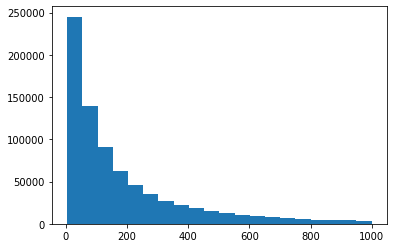

In [ ]:
plt.hist(user_counts[user_counts>4][user_counts<1000], bins=20)
plt.show()

In [ ]:
# Look at the raw distribution of book ratings
print(len(book_counts))
# print(len(user_counts[user_counts<1000]))
print(len(book_counts[book_counts>14]))
print('Full:', np.histogram(book_counts, bins=20))
print('< 25:', np.histogram(book_counts[book_counts < 25], bins=23))

2360650
960327
Full: (array([2359461,     747,     196,     102,      50,      23,      18,
             9,      14,       8,       3,       2,      10,       2,
             1,       0,       2,       0,       0,       2]), array([1.000000e+00, 1.573520e+04, 3.146940e+04, 4.720360e+04,
       6.293780e+04, 7.867200e+04, 9.440620e+04, 1.101404e+05,
       1.258746e+05, 1.416088e+05, 1.573430e+05, 1.730772e+05,
       1.888114e+05, 2.045456e+05, 2.202798e+05, 2.360140e+05,
       2.517482e+05, 2.674824e+05, 2.832166e+05, 2.989508e+05,
       3.146850e+05]))
< 25: (array([303590, 208068, 157201, 124533, 103510,  87777,  75528,  66017,
        58111,  52080,  46880,  42446,  38946,  35636,  32362,  30144,
        27707,  25909,  24286,  22662,  21074,  20017,  36229]), array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]))


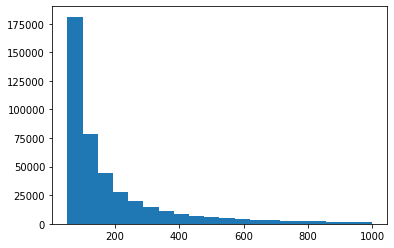

In [ ]:
plt.hist(book_counts[book_counts>50][book_counts < 1000], bins=20)
plt.show()

In [ ]:
print(book_counts)

book_id
0          895
1          215
2          128
5          326
6          252
          ... 
1839603     56
1854807     79
1983592     55
1985003     51
2016570     52
Name: user_id, Length: 428309, dtype: int64


# Preprocessing

In [ ]:
# Split into train/val/test 

def split_train_val_test():
    '''
    Takes ~10-15 minutes.
    '''
    if os.path.exists(os.path.join(DATA_PATH, 'goodreads_interactions-clean-train.csv')):
        print('Already Split')
        return

    user_counts, book_counts, n_total_ratings = gather_userbook_rating_counts(popular_workflow=True)
    print('{} users, {} books'.format(len(user_counts), len(book_counts)))

    BATCH_SIZE = 1000000
    output_path_train = os.path.join(DATA_PATH, 'goodreads_interactions-clean-train.csv')
    output_path_val = os.path.join(DATA_PATH, 'goodreads_interactions-clean-val.csv')
    output_path_test = os.path.join(DATA_PATH, 'goodreads_interactions-clean-test.csv')
    output_path_clean_val = os.path.join(DATA_PATH, 'goodreads_interactions-clean-val_clean.csv')
    output_path_clean_test = os.path.join(DATA_PATH, 'goodreads_interactions-clean-test_clean.csv')

    # In val/test we want clean (untrained on) users and unclean (trained on but not those ratings) users 
    # clean percentages are out of users
    # unclean percentages are out of ratings
    p_test, p_test_clean = 0.075, 0.005
    p_val, p_val_clean = 0.075, 0.005

    val_clean_userids = user_counts[-int(len(user_counts)*p_val_clean):]
    test_clean_userids = user_counts[-int(len(user_counts)*(p_test_clean+p_val_clean)) \
                                    :-int(len(user_counts)*p_val_clean)]
    unclean_userids = user_counts[:-int(len(user_counts)*(p_test_clean+p_val_clean))]

    print('Train user count: {}, val clean: {}, test clean: {}'.format(
        len(unclean_userids), len(val_clean_userids), len(test_clean_userids))
    )

    n_total_ratings, n_train, n_val = 0, 0, 0
    with pd.read_csv(os.path.join(DATA_PATH, 'goodreads_interactions-clean.csv'), 
                    chunksize=BATCH_SIZE
                    ) as reader:
        for chunk in reader:

            df_clean_val = chunk[chunk['user_id'].isin(val_clean_userids.index)]
            df_clean_test = chunk[chunk['user_id'].isin(test_clean_userids.index)]
            df_unclean = chunk[chunk['user_id'].isin(unclean_userids.index)]

            # Grab unclean user indexes
            unclean_rating_idxs = np.random.permutation(len(df_unclean))
            unclean_rating_idxs_train = unclean_rating_idxs[:-int((p_test+p_val)*len(unclean_rating_idxs))]
            unclean_rating_idxs_val = unclean_rating_idxs[-int(p_val*len(unclean_rating_idxs)):]
            unclean_rating_idxs_test = unclean_rating_idxs[-int((p_test+p_val)*len(unclean_rating_idxs)): 
                                                        -int(p_val*len(unclean_rating_idxs))]

            df_train = df_unclean.iloc[unclean_rating_idxs_train]
            # Shuffle Train set
            df_train = df_train.sample(frac=1).reset_index(drop=True)
            df_val = df_unclean.iloc[unclean_rating_idxs_val]
            df_test = df_unclean.iloc[unclean_rating_idxs_test]
            
            # Output to CSV
            output_name_df = [(output_path_clean_val, df_clean_val), (output_path_clean_test, df_clean_test), 
                    (output_path_train, df_train), (output_path_val, df_val), (output_path_test, df_test)]
            for output_name, df in output_name_df:
                df.to_csv(output_name, mode='a', header=not os.path.exists(output_name))

            n_total_ratings += len(chunk)
            n_train += len(df_train)
            n_val += len(df_val)

    print('Total ratings: {}, Train: {}, Val: {}'.format(
        n_total_ratings, 
        n_train, 
        n_val))


def split_train():
    ''' Splits train into local csv splits of 2M examples each.
    Takes ~5-10 minutes.
    '''
    BATCH_SIZE = 2000000
    with pd.read_csv(os.path.join(DATA_PATH, 'goodreads_interactions-clean-train.csv'), 
                    chunksize=BATCH_SIZE
                    ) as reader:
        for i, chunk in enumerate(reader):
            chunk.to_csv('train_split_{}.csv'.format(i))
    return i + 1

In [ ]:
def get_workflow(load_path:str = None) -> nvt.Workflow:
    ''' Loads the Workflow or creates a new one if load_path is None.'''
    if load_path:
        print('Loading Workflow')
        workflow = nvt.Workflow.load(load_path)

    else:
        print('Creating Workflow')
        # map from ratings id to goodreads id
        joined = ["user_id", "book_id"] >> nvt.ops.JoinExternal(df_idmap, on="book_id")
        output = joined['user_id', 'goodreads_id'] >> nvt.ops.Categorify()
        output += nvt.ColumnGroup(["rating"]) >> nvt.ops.NormalizeMinMax()
        workflow = nvt.Workflow(output)

    return workflow

In [ ]:
def partition_fit_and_transform(workflow: nvt.Workflow):
    ''' Fits the workflow on splits of the train dataset
        then transforms the train/val/test datasets.
    '''
    if os.path.exists(os.path.join(DATA_PATH, 'goodreads_interactions-clean-train')):
        print('Already fit')
        return

    print('Splitting ...')
    n_splits = split_train()
    print('Fitting ...')
    ds = nvt.Dataset(['train_split_{}.csv'.format(i) for i in range(n_splits)])
    workflow.fit(ds)
    print('Transforming ...')
    path = os.path.join(DATA_PATH, 'goodreads_interactions-clean-train')
    workflow.transform(ds).to_parquet(path, preserve_files=True)

    # Transform val/test
    workflow.transform(
        nvt.Dataset(os.path.join(DATA_PATH, 'goodreads_interactions-clean-val.csv'))
        ).to_parquet(os.path.join(DATA_PATH, 'goodreads_interactions-clean-val'))
    workflow.transform(
        nvt.Dataset(os.path.join(DATA_PATH, 'goodreads_interactions-clean-test.csv'))
        ).to_parquet(os.path.join(DATA_PATH, 'goodreads_interactions-clean-test'))

In [ ]:
# Note: total ratings are before filtering with popular workflow whereas train/val counts are after
split_train_val_test()

750823 users, 606690 books
Train user count: 743315, val clean: 3754, test clean: 3754
Total ratings: 168957291, Train: 97264497, Val: 8582074


In [ ]:
df_idmap = pd.read_csv(os.path.join(DATA_PATH, 'book_id_map-dedup-v1.csv'))
df_idmap = df_idmap.drop(columns=['Unnamed: 0'])
df_idmap = df_idmap.rename(columns={'book_id': 'goodreads_id'})
df_idmap = df_idmap.rename(columns={'book_id_csv': 'book_id'})

# Load in or create Workflow
workflow_path = os.path.join(DATA_PATH, 'book_workflow_popular-v1')
exists = os.path.exists(workflow_path)
workflow = get_workflow(workflow_path if exists else None)

# Transform dataset if needed
partition_fit_and_transform(workflow)

# Save workflow if needed
if not exists:
    print('Saving Workflow')
    workflow.save(workflow_path)

Loading Workflow
Already fit


In [ ]:
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,user_id,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.user_id.parquet,0.0,743312.0,user_id,743313.0,512.0
1,goodreads_id,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.goodreads_id.parquet,0.0,827097.0,goodreads_id,827098.0,512.0
2,rating,(Tags.CONTINUOUS),float64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Loading

In [ ]:
def load_dls(batch_size):
    ''' Load in the transformed datasets and convert to torch-ready
    '''
    train_path = os.path.join(DATA_PATH, 'goodreads_interactions-clean-train')
    train_paths = [os.path.join(train_path, x) for x in os.listdir(train_path) \
                   if '.parquet' in x]

    train_torch = TorchAsyncItr(
        nvt.Dataset(train_paths, engine='parquet'),
        batch_size=batch_size,
        cats=['user_id', 'goodreads_id'],
        conts=["rating"], 
        shuffle=True
    )
    train_dl = DLDataLoader(
        train_torch, batch_size=None, pin_memory=False, num_workers=0
    )

    val_path = os.path.join(DATA_PATH, 'goodreads_interactions-clean-val')
    val_torch = TorchAsyncItr(
        nvt.Dataset(val_path, engine='parquet'),
        batch_size=batch_size,
        cats=['user_id', 'goodreads_id'],
        conts=["rating"], 
    )
    val_dl = DLDataLoader(
        val_torch, batch_size=None, pin_memory=False, num_workers=0
    )
    
    test_path = os.path.join(DATA_PATH, 'goodreads_interactions-clean-test')
    test_torch = TorchAsyncItr(
        nvt.Dataset(test_path, engine='parquet'),
        batch_size=batch_size,
        cats=['user_id', 'goodreads_id'],
        conts=["rating"], 
    )
    test_dl = DLDataLoader(
        test_torch, batch_size=None, pin_memory=False, num_workers=0
    )
    return train_dl, val_dl, test_dl

# Models and Training Loops

## Models

In [ ]:
class MLP(nn.Module):
    def __init__(self, emb_size, hidden_dim, n_users, n_media, dropout_rate=0.0):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.media_emb = nn.Embedding(n_media, emb_size)
        self.emb_dropout = nn.Dropout(p=dropout_rate)

        self.mlp = nn.Sequential(nn.Linear(emb_size*2, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(p=dropout_rate),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(p=dropout_rate),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(p=dropout_rate),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(hidden_dim, 1))

    def forward(self, user, media):
        x = torch.cat([self.user_emb(user).transpose(1, 2), 
                       self.media_emb(media).transpose(1, 2)], axis=1).squeeze()
        x = self.emb_dropout(x)
        return torch.sigmoid(self.mlp(x))

## Training Loop

In [ ]:
def train_model(train_dl, val_dl, test_dl, model, loss_fn, opt):
    metrics = []

    for epoch in range(epochs):
        start = time.time()

        mse, rmse = train(train_dl, model, loss_fn, opt, epoch+1)
        val_mse, val_rmse = validate(val_dl, model, loss_fn, epoch+1)

        metrics.append([mse, rmse, val_mse, val_rmse])
        print('Epoch {}/{} - completed {}M - est. remaining {}H {}M \n'.format(
                                                            epoch+1, epochs, 
                                                            int((time.time()-start) // 60), 
                                                            int((time.time()-start) // 60 * (epochs - epoch-1) // 60),
                                                            int((time.time()-start) // 60 * (epochs - epoch-1) % 60)
                                                            ))
    
    return metrics

In [ ]:
def train(train_dl, model, loss_fn, opt, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    
    model.train()

    # for i, train_dl in enumerate(train_dls):
    for i, (x, _) in enumerate(train_dl):
        user = x['user_id'].to('cuda')
        media = x['goodreads_id'].to('cuda')
        y = x['rating'].to('cuda').to(torch.float32)

        pred = model(user, media)
        pred = pred.squeeze()

        loss = loss_fn(pred, y)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses += [loss.detach()*len(y)]
        n_examples += len(y)

        if (i+1) % (30000000//8192) == 0:
            print('Train: Epoch {} - {} - loss {:.3f} - rmse {:.3f}'.format(
                                                                    epoch, n_examples,
                                                                    torch.tensor(losses).sum()/n_examples, 
                                                                    (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()


def validate(val_dl, model, loss_fn, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    model.eval()

    for i, (x, _) in enumerate(val_dl):
        user = x['user_id'].to('cuda')
        media = x['goodreads_id'].to('cuda')
        y = x['rating'].to('cuda').to(torch.float32)

        with torch.no_grad():
            pred = model(user, media)
            pred = pred.squeeze()

            loss = loss_fn(pred, y)

        losses += [loss*len(y)]
        n_examples += len(y)

    print('Eval: Epoch {} - loss {:.3f} - rmse {:.3f}'.format(
                                                      epoch,
                                                      torch.tensor(losses).sum()/n_examples, 
                                                      (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()

# Experiments

In [ ]:
batch_size = 8192
train_dl, val_dl, test_dl = load_dls(batch_size)

In [ ]:
# Normalize + sigmoid + Popular workflow
emb_size, hidden_dim = 32, 128
cat_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLP(emb_size, hidden_dim,
            n_users=cat_emb_shape['user_id'][0], 
            n_media=cat_emb_shape['goodreads_id'][0],
            dropout_rate=0.)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 3
train_model(train_dl, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - 29999104 - loss 0.126 - rmse 0.354
Train: Epoch 1 - 59998208 - loss 0.122 - rmse 0.349
Train: Epoch 1 - 89997312 - loss 0.121 - rmse 0.347
Eval: Epoch 1 - loss 0.122 - rmse 0.349
Epoch 1/3 - completed 5M - est. remaining 0H 10M 

Train: Epoch 2 - 29999104 - loss 0.114 - rmse 0.338
Train: Epoch 2 - 59998208 - loss 0.113 - rmse 0.336
Train: Epoch 2 - 89997312 - loss 0.112 - rmse 0.335
Eval: Epoch 2 - loss 0.119 - rmse 0.345
Epoch 2/3 - completed 5M - est. remaining 0H 5M 

Train: Epoch 3 - 29999104 - loss 0.111 - rmse 0.333
Train: Epoch 3 - 59998208 - loss 0.110 - rmse 0.331
Train: Epoch 3 - 89997312 - loss 0.109 - rmse 0.329
Eval: Epoch 3 - loss 0.120 - rmse 0.346
Epoch 3/3 - completed 5M - est. remaining 0H 0M 



[[tensor(0.1216), tensor(0.3486), tensor(0.1221), tensor(0.3495)],
 [tensor(0.1125), tensor(0.3355), tensor(0.1190), tensor(0.3450)],
 [tensor(0.1086), tensor(0.3295), tensor(0.1198), tensor(0.3462)]]

In [ ]:
trace_model(model, os.path.join(DATA_PATH, 'mlp_4l_32emb_128h_1e-2lradam_0d_3e--02_20_23.pt'))

In [ ]:
# Normalize + sigmoid + Popular workflow + short model
emb_size, hidden_dim = 32, 128
cat_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLP(emb_size, hidden_dim,
            n_users=cat_emb_shape['user_id'][0], 
            n_media=cat_emb_shape['goodreads_id'][0],
            dropout_rate=0.)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 10
train_model(train_dl, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - 29999104 - loss 0.123 - rmse 0.351
Train: Epoch 1 - 59998208 - loss 0.121 - rmse 0.348
Train: Epoch 1 - 89997312 - loss 0.120 - rmse 0.346
Eval: Epoch 1 - loss 0.127 - rmse 0.357
Epoch 1/10 - completed 4M - est. remaining 0H 36M 

Train: Epoch 2 - 29999104 - loss 0.114 - rmse 0.338
Train: Epoch 2 - 59998208 - loss 0.113 - rmse 0.336
Train: Epoch 2 - 89997312 - loss 0.112 - rmse 0.335
Eval: Epoch 2 - loss 0.123 - rmse 0.350
Epoch 2/10 - completed 4M - est. remaining 0H 32M 

Train: Epoch 3 - 29999104 - loss 0.111 - rmse 0.333
Train: Epoch 3 - 59998208 - loss 0.109 - rmse 0.331
Train: Epoch 3 - 89997312 - loss 0.108 - rmse 0.329
Eval: Epoch 3 - loss 0.124 - rmse 0.352
Epoch 3/10 - completed 4M - est. remaining 0H 28M 



KeyboardInterrupt: ignored

In [ ]:
# Normalize + sigmoid + Popular workflow + Dropout
emb_size, hidden_dim = 32, 128
cat_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLP(emb_size, hidden_dim,
            n_users=cat_emb_shape['user_id'][0], 
            n_media=cat_emb_shape['goodreads_id'][0],
            dropout_rate=0.2)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 10
train_model(train_dl, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - 29999104 - loss 0.128 - rmse 0.357
Train: Epoch 1 - 59998208 - loss 0.124 - rmse 0.353
Train: Epoch 1 - 89997312 - loss 0.123 - rmse 0.351
Eval: Epoch 1 - loss 0.121 - rmse 0.348
Epoch 1/10 - completed 5M - est. remaining 0H 45M 

Train: Epoch 2 - 29999104 - loss 0.117 - rmse 0.342
Train: Epoch 2 - 59998208 - loss 0.116 - rmse 0.341
Train: Epoch 2 - 89997312 - loss 0.115 - rmse 0.340
Eval: Epoch 2 - loss 0.119 - rmse 0.345
Epoch 2/10 - completed 5M - est. remaining 0H 40M 

Train: Epoch 3 - 29999104 - loss 0.115 - rmse 0.339


KeyboardInterrupt: ignored

# Evaluation

In [ ]:
# TODO: Extract a user's ratings

# Create DL to test specific user
book_ids = np.unique(df_idmap['book_id'])
user_df = pd.DataFrame({'user_id': [-1]*len(book_ids), 'book_id': book_ids, 'rating': [0]*len(book_ids)})

# user_df = df_ratings[df_ratings['userId'] == 72315]
user_ds = nvt.Dataset(user_df)

torch_ds = TorchAsyncItr(
    workflow.transform(user_ds),
    batch_size=1024,
    cats=['user_id', 'goodreads_id'],
    conts=["rating"], 
)
dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [ ]:
# Test most popular user
loss_fn = nn.MSELoss()
validate(dl, model, loss_fn, -1)

In [ ]:
preds = []

model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    y = x['rating'].to('cuda')

    with torch.no_grad():
        pred = model(user, media)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:2])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

In [ ]:
# Test against default embedding
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
test_model = prodMLP(model, default_user_emb, model.media_emb.weight.detach())

preds = []

test_model.cuda()
test_model.eval()
for i, (x, _) in enumerate(dl):
    media = x['goodreads_id']
    # Remove any media not in training data
    idxs = (media>0).squeeze()
    media = media[idxs].to('cuda')
    user = x['user_id'][idxs].to('cuda')
    # print(torch.max(user))
    y = x['rating'][idxs].to('cuda')

    with torch.no_grad():
        pred = test_model(user, media)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

sorted_preds = sorted(zip(preds, book_ids), key=lambda x: x[0], reverse=True)
print(sorted_preds[:5])

[(tensor(0.9820), 7276), (tensor(0.9820), 92385), (tensor(0.9741), 68616), (tensor(0.9741), 1117756), (tensor(0.9734), 311399)]


In [ ]:
df_idmap[df_idmap['book_id']==68616]

,book_id,goodreads_id
48608,68616,375990


# Production

In [ ]:
def trace_model(model, path):
    model.to('cpu')
    model.eval()

    inp = (torch.randint(1, 10000, (16,1)), 
        torch.randint(1, 10000, (16,1)))
    traced_model = torch.jit.trace(model, inp)
    traced_model.save(path)

In [ ]:
# Production models from trained models/embeddings
import copy

def prodMLP(model, prod_user_emb, train_media_emb):
    prod_model = copy.deepcopy(model)
    prod_model.user_emb = nn.Embedding.from_pretrained(prod_user_emb, freeze=True)
    prod_model.media_emb = nn.Embedding.from_pretrained(train_media_emb, freeze=True)
    return prod_model

In [ ]:
def extract_prod_user_emb(train_emb: torch.Tensor, start_idx: int, end_idx: int=None) -> torch.Tensor:
    ''' Extracts the default user embedding and real user embedding for use in production.
        The default embedding is taken as the average embedding of real and train users 
        (for the time being).
    
    Args:
      train_emb: the embedding tensor from the trained model.
      start_idx: the start idx in the train_emb of the real users. 
        If none then just extract default.
      end_idx: the end idx in the train_emb of the real users.
        If none then use up through last idx.

    Returns:
      The concatenated [default embedding, real user embedding]
    '''
    default_emb = torch.mean(train_emb, dim=0, keepdim=True)
    if start_idx is None:
      return default_emb
    emb = train_emb[start_idx:end_idx+1] if end_idx is not None else train_emb[start_idx:]
    return torch.cat([default_emb, emb], axis=0)

## Cluster Embeddings
An efficient way to adjust to the user's preferences early on before we have enough training data for the user. \\
We first cluster the user embeddings of the model. We then take the average ratings for each cluster and map \\
the user to the closest cluster by their ratings. We use this cluster's embedding for the user. Each time the user  \\
rates something new the embedding can be adjusted as needed without training.

In [ ]:
import torch
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
model = torch.jit.load(
    os.path.join(DATA_PATH, 'mlp_4l_32emb_128h_1e-2lradam_0d_3e--02_20_23.pt')
    )
user_embs = model.user_emb.weight.clone().detach().numpy()

In [ ]:
user_embs.shape

(743313, 32)

### Figure out K

In [ ]:
ssd = []
cluster_sizes = [10,20,50,100,150,200,500,1000,2000,5000,10000]
for n_clusters in cluster_sizes:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters).fit(user_embs)
    ssd.append(kmeans.inertia_)
    print(n_clusters, kmeans.inertia_)

10 30481936.0
20 28808806.0
50 26880458.0
100 25652400.0
150 24995686.0
200 24548728.0
500 23171704.0
1000 22184494.0
2000 21177758.0
5000 19840266.0
10000 22538924.0


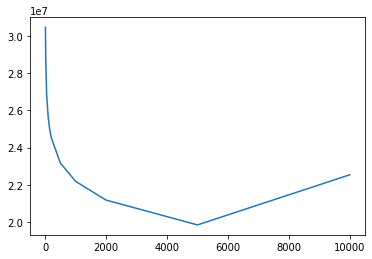

In [ ]:
plt.plot(cluster_sizes, ssd)

### Final Clustering

In [ ]:
n_clusters = 500

kmeans = MiniBatchKMeans(n_clusters=n_clusters).fit(user_embs)

In [ ]:
kmeans.inertia_

23156248.0

In [ ]:
# Look at label distribution
print(kmeans.labels_)
print(np.histogram(kmeans.labels_, bins=20))

[140 258 125 ...   9 493 446]
(array([41033, 38647, 36630, 36463, 36334, 38430, 41075, 36517, 38331,
       36220, 36504, 35186, 40252, 40935, 36645, 32097, 39120, 36759,
       34861, 31274]), array([  0.  ,  24.95,  49.9 ,  74.85,  99.8 , 124.75, 149.7 , 174.65,
       199.6 , 224.55, 249.5 , 274.45, 299.4 , 324.35, 349.3 , 374.25,
       399.2 , 424.15, 449.1 , 474.05, 499.  ]))


In [ ]:
# Look at centroids
print(kmeans.cluster_centers_)
norm = torch.norm(torch.tensor(kmeans.cluster_centers_), dim=1)
print(np.histogram(norm, bins=20))

[[ 1.5540259e+00 -4.4206059e-01 -1.4302121e-01 ...  1.4149971e+00
   1.0822490e+00  3.0509502e-01]
 [ 2.7789828e-01 -3.1944099e-01  4.5839405e-01 ...  6.4129990e-01
  -5.9602547e-02  6.8693841e-01]
 [-1.9379914e+00 -1.8769772e+00  2.1123948e+00 ...  1.3466828e+00
   9.9314779e-01 -2.1987462e+00]
 ...
 [ 3.3640349e-01  1.1995438e-03  3.1560275e-01 ... -1.2306819e+00
  -1.3515763e+00  1.2175084e-01]
 [-2.8880504e-01  9.0865850e-01  3.0839983e-01 ...  9.7966686e-02
  -3.9981684e-01 -6.8123543e-01]
 [ 7.4281895e-01  1.0470992e+00 -1.4653597e+00 ... -1.0181879e-01
   8.8746423e-01  3.8632560e-01]]
(array([20, 60, 76, 64, 62, 45, 35, 32, 32, 17, 12, 18,  9,  5,  5,  1,  3,
        0,  1,  3]), array([ 2.2860994,  2.8503304,  3.4145615,  3.9787924,  4.5430236,
        5.1072545,  5.6714854,  6.2357163,  6.7999477,  7.3641787,
        7.9284096,  8.4926405,  9.056871 ,  9.621102 , 10.185333 ,
       10.749565 , 11.313796 , 11.878027 , 12.442258 , 13.006489 ,
       13.57072  ], dtype=float32))

In [ ]:
np.save(os.path.join(DATA_PATH, 'book_cluster_centroids_500--02_20_23'), kmeans.cluster_centers_)
np.save(os.path.join(DATA_PATH, 'book_cluster_labels_500--02_20_23'), kmeans.labels_)

In [ ]:
# Load train_dl
batch_size = 1024
train_path = os.path.join(DATA_PATH, 'goodreads_interactions-clean-train')
train_paths = [os.path.join(train_path, x) for x in os.listdir(train_path) \
                if '.parquet' in x]

train_torch = TorchAsyncItr(
    nvt.Dataset(train_paths, engine='parquet'),
    batch_size=batch_size,
    cats=['user_id', 'goodreads_id'],
    conts=["rating"], 
)
train_dl = DLDataLoader(
    train_torch, batch_size=None, pin_memory=False, num_workers=0
)

In [ ]:
cluster_labels = np.load(os.path.join(DATA_PATH, 'book_cluster_labels_500--02_20_23.npy'))
n_clusters = 500

In [ ]:
# Vector Version
# cat_emb_shape = nvt.ops.get_embedding_sizes(workflow)
# n_users = cat_emb_shape['user_id'][0]
# n_media = cat_emb_shape['goodreads_id'][0]

# ratings = np.zeros((n_clusters, n_media))
# counts = np.zeros((n_clusters, n_media))

# for x, _ in train_dl:
#     user = x['user_id'].numpy().squeeze()
#     cluster = cluster_labels[user]
#     media = x['goodreads_id'].numpy().squeeze()
#     y = x['rating'].numpy().squeeze()
    
#     for i in range(len(user)):
#         if user[i] == 0: continue
#         ratings[cluster[i], media[i]] += y[i]
#         counts[cluster[i], media[i]] += 1.

# ratings *= 5
# # Only count ratings by majority 
# # ratings = ratings[counts >= 10]
# ratings /= counts
# ratings[np.isnan(ratings)] = 0.

# np.save(os.path.join(DATA_PATH, 'book_cluster_ratings_500--02_20_23'), ratings)

# Dict Version
cat_emb_shape = nvt.ops.get_embedding_sizes(workflow)
n_users = cat_emb_shape['user_id'][0]
n_media = cat_emb_shape['goodreads_id'][0]

ratings = {i:{} for i in range(n_clusters)} 
counts =  {i:{} for i in range(n_clusters)} 

for x, _ in train_dl:
    user = x['user_id'].numpy().squeeze()
    # cluster = kmeans.labels_[user]
    cluster = cluster_labels[user]
    media = x['goodreads_id'].numpy().squeeze()
    y = x['rating'].numpy().squeeze()
    
    for i in range(len(user)):
        if user[i] == 0: continue
        if media[i] in ratings[cluster[i]]:
            ratings[cluster[i]][media[i]] += y[i]
            counts[cluster[i]][media[i]] += 1.
        else:
            ratings[cluster[i]][media[i]] = y[i]
            counts[cluster[i]][media[i]] = 1.

# Gather average rating
del_ratings = []
for i, cluster in ratings.items():
    for media, rating in cluster.items():
        # Only include ratings if 5 or more people in cluster have rated
        if counts[i][media] < 5:
            del_ratings.append((i,media))
        else:
            cluster[media] /= counts[i][media]
            cluster[media] *= 5

for i, media in del_ratings:
    del ratings[i][media]


cluster_ratings = {}
for i, cluster in ratings.items():
    cluster_ratings[i] = {}
    for media, rating in cluster.items():
        cluster_ratings[i][int(media)] = rating

with open(os.path.join(DATA_PATH, 'book_cluster_ratings_500-nolt5--02_20_23.json'), 'w') as f: 
    json.dump(cluster_ratings, f)

In [ ]:
len(del_ratings), sum([len(i) for i in cluster_ratings.values()])

(27694647, 3390837)

In [ ]:
# Can't reassign to torchscript models so load state dict from ts model into new model
ts_model = model
emb_size, hidden_dim = 32, 128
cat_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLP(emb_size, hidden_dim, 
            n_users=cat_emb_shape['user_id'][0],
            n_media=cat_emb_shape['goodreads_id'][0])
model.load_state_dict(ts_model.state_dict())

<All keys matched successfully>

In [ ]:
# Concatenate default (avg) with clusters
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
centroids = torch.tensor(np.load(os.path.join(DATA_PATH, 'book_cluster_centroids_500--02_20_23.npy')))
# centroids = torch.tensor(kmeans.cluster_centers_)

test_model = prodMLP(model, torch.cat([default_user_emb, centroids], axis=0), model.media_emb.weight.detach())

In [ ]:
test_model.to('cpu')
test_model.eval()

inp = (torch.zeros((1024,1), dtype=int), 
       torch.randint(1, 10000, (1024,1)))
traced_model = torch.jit.trace(test_model, inp)

traced_model.save(os.path.join(DATA_PATH, 'mlp_cluster500_4l_32emb_128h_1e-2lradam_0d_3e--book--02_20_23.pt'))

In [ ]:
# Create DL to test specific user
book_ids = np.unique(df_idmap['book_id'])
user_df = pd.DataFrame({'user_id': [-1]*len(book_ids), 'book_id': book_ids, 'rating': [0]*len(book_ids)})

# user_df = df_ratings[df_ratings['userId'] == 72315]
user_ds = nvt.Dataset(user_df)

torch_ds = TorchAsyncItr(
    workflow.transform(user_ds),
    batch_size=1024,
    cats=['user_id', 'goodreads_id'],
    conts=["rating"], 
)
dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [ ]:
preds = []

# test_model.cuda()
test_model.eval()
for i, (x, _) in enumerate(dl):
    media = x['goodreads_id']
    # Remove any media not in training data
    idxs = (media>0).squeeze()
    media = media[idxs] #.to('cuda')
    user = x['user_id'][idxs] #.to('cuda')
    y = x['rating'][idxs] #.to('cuda')

    with torch.no_grad():
        pred = test_model(user, media)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

sorted_preds = sorted(zip(preds, book_ids), key=lambda x: x[0], reverse=True)
print(sorted_preds[:5])

In [86]:
# def get_workflow_ratings_vector(user_ratings, n_media):
#     ''' Computes the ratings vector from original ratings for use in clustering.

#     Args:
#       user_ratings: [{'bookId': int, 'rating': float}]
#       n_media: int. Length of rating vectors in clusters
#     '''
#     ratings_vector = np.zeros(n_media)
#     book_ids = [r['bookId'] for r in user_ratings]
#     book_ratings = [r['rating'] for r in user_ratings]
#     df = pd.DataFrame({'user_id': [-1]*len(book_ids), # Maps to 0
#                         'book_id': book_ids,
#                         'rating': book_ratings})
#     # Throw away values for join
#     df_idmap = pd.DataFrame({'book_id': book_ids, 'book_id_csv': book_ids})

#     ds = nvt.Dataset(df)
#     torch_ds = TorchAsyncItr(
#         workflow.transform(ds),
#         batch_size=1,
#         cats=['user_id', 'goodreads_id'],
#         conts=["rating"], 
#     )
#     dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)
#     for x, _ in dl:
#         media = x['goodreads_id']
#         y = x['rating']
#         ratings_vector[media] = y*5
    
#     return ratings_vector
    

# def find_closest_cluster(user_ratings, cluster_ratings):
#     diff = np.linalg.norm(cluster_ratings*(user_ratings>0) - user_ratings, axis=1)
#     cluster = np.argmin(diff)
#     return cluster


def get_workflow_ratings_vector(user_ratings):
    ''' Computes the ratings vector from original ratings for use in clustering.

    Args:
      user_ratings: [{'bookId': int, 'rating': float}]
    '''

    df_idmap = pd.read_csv(os.path.join(DATA_PATH, 'book_id_map-dedup-v1.csv'))
    df_idmap = df_idmap.drop(columns=['Unnamed: 0'])
    df_idmap = df_idmap.rename(columns={'book_id': 'goodreads_id'})
    df_idmap = df_idmap.rename(columns={'book_id_csv': 'book_id'})
    
    book_ids, goodreads_ids, book_ratings = [], [], []
    for r in user_ratings:
        bids = df_idmap[df_idmap['goodreads_id'] == r['bookId']]['book_id']
        if len(bids) == 0:
            continue
        book_ids.append(bids.iloc[0])
        goodreads_ids.append(r['bookId'])
        book_ratings.append(int(r['rating']))

    print(book_ids)
    ratings_vector = np.array(book_ratings)
    df = pd.DataFrame({'user_id': [-1]*len(book_ids),
                        'book_id': book_ids,
                        'rating': book_ratings})
    # Throw away values for join
    # df_idmap = pd.DataFrame({'book_id': book_ids, 'goodreads_id': goodreads_ids})

    ds = nvt.Dataset(df)
    torch_ds = TorchAsyncItr(
        workflow.transform(ds),
        batch_size=1,
        cats=['user_id', 'goodreads_id'],
        conts=["rating"], 
    )
    dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)

    id_vector = np.array([x['goodreads_id'][0][0].numpy() for x, _ in dl])
    print(id_vector)

    return ratings_vector, id_vector
    

def find_closest_cluster(user_ratings, user_bookids, cluster_ratings):
    # Extract cluster rating matrix to match user_rating vector
    cluster_ratings_mat = np.zeros((len(cluster_ratings), len(user_ratings)))
    for rating_idx, id in enumerate(user_bookids):
        for i, cluster in cluster_ratings.items():
            cluster_ratings_mat[int(i)][rating_idx] = cluster[str(id)] if str(id) in cluster else 0

    diff = np.linalg.norm(cluster_ratings_mat - user_ratings, axis=1)
    cluster = np.argmin(diff)
    return cluster


def load_cluster_ratings(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

In [71]:
df_idmap_real = pd.read_csv(os.path.join(DATA_PATH, 'book_id_map-dedup-v1.csv'))
df_idmap_real = df_idmap_real.drop(columns=['Unnamed: 0'])
df_idmap_real = df_idmap_real.rename(columns={'book_id': 'goodreads_id'})
df_idmap_real = df_idmap_real.rename(columns={'book_id_csv': 'book_id'})
df_idmap_real[df_idmap_real['goodreads_id'] == 22543496]

,book_id,goodreads_id
73,119,22543496
21200,27626,22543496
971592,2228619,22543496


In [88]:
cat_emb_shape = nvt.ops.get_embedding_sizes(workflow)
n_media = cat_emb_shape['goodreads_id'][0]
# Harry Potter's 1-3
# r = [{'bookId': 5, 'rating': 5}, {'bookId': 15881, 'rating': 5}, 
#      {'bookId': 3, 'rating': 5}]

# Nonfiction
r = [
    {'bookId': 11084145, 'rating': 5.0}, 
     {'bookId': 52036, 'rating': 5.0}, 
     {'bookId': 3228917, 'rating': 4.0}, 
     {'bookId': 8520610, 'rating': 4.0}, 
     {'bookId': 12609433, 'rating': 4.0}, 
     {'bookId': 11468377, 'rating': 4.0}, 
     {'bookId': 629, 'rating': 5.0}, 
     {'bookId': 10569, 'rating': 4.0}, 
     {'bookId': 6289283, 'rating': 4.0}, 
     {'bookId': 6732019, 'rating': 4.0}, 
     {'bookId': 22543496, 'rating': 4.0}, 
     {'bookId': 23692271, 'rating': 5.0}, 
     {'bookId': 22463, 'rating': 4.0}, 
     {'bookId': 615570, 'rating': 5.0}, 
     {'bookId': 1301, 'rating': 5.0}, 
     {'bookId': 38210, 'rating': 4.0}, 
     {'bookId': 28257707, 'rating': 3.0}, 
     {'bookId': 2195464, 'rating': 5.0}, 
     {'bookId': 12543, 'rating': 4.0}, 
     {'bookId': 18050143, 'rating': 4.0}, 
     {'bookId': 6346975, 'rating': 3.0}, 
     {'bookId': 6480781, 'rating': 5.0}, 
     {'bookId': 4866, 'rating': 4.0}
     ]

ratings_vector, id_vector = get_workflow_ratings_vector(r)
cluster = find_closest_cluster(ratings_vector, id_vector,
                               load_cluster_ratings(os.path.join(DATA_PATH, 'book_cluster_ratings_500-nolt5--02_20_23.json')))

[21164, 8426, 619, 412, 387, 369, 1294, 8462, 365, 534, 119, 18151, 21041, 35047, 507, 17591, 29015, 17582, 32329, 228, 20514, 68, 171]
[ 250  209  253  213  496  427  621  326 1207 2285 1430  722 1138 1816
 2845 1391 1189 1381 1048 2182 1382 3713 2588]


In [ ]:
print(ratings_vector, id_vector)
cluster

[5 5 5] [54516 19158 10675]


300

In [ ]:
curr_cluster_ratings = load_cluster_ratings(os.path.join(DATA_PATH, 'book_cluster_ratings_500-nolt5--02_20_23.json'))[str(cluster)]
for x in id_vector:
    if str(x) in curr_cluster_ratings:
        print(x, curr_cluster_ratings[str(x)])

19158 3.8750000670552254
10675 4.166666691501935


In [ ]:
model = torch.jit.load(os.path.join(DATA_PATH, 'mlp_cluster500_4l_32emb_128h_1e-2lradam_0d_3e--book--02_20_23.pt'))

In [ ]:
preds = []

# model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    media = x['goodreads_id']
    # Remove any media not in training data
    idxs = (media>0).squeeze()
    media = media[idxs] #.to('cuda')
    user = x['user_id'][idxs] + cluster + 1 #.to('cuda') # +1 for default embedding
    y = x['rating'][idxs] #.to('cuda')

    with torch.no_grad():
        pred = model(user, media)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

sorted_preds = sorted(zip(preds, book_ids), key=lambda x: x[0], reverse=True)
print(sorted_preds[:5])

[(tensor(0.9732), 7665), (tensor(0.9698), 86758), (tensor(0.9687), 143955), (tensor(0.9680), 63973), (tensor(0.9669), 664269)]


In [ ]:
df_idmap[df_idmap['book_id'] == 63973]

,book_id,goodreads_id
45153,63973,93220
